# Time evolution for multiple spins
-----------------------------------------------------------

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

Here we use the machinery developed in the single-spin case to perform time evolution on a system of multiple spins. One additional feature we will need is the gate $\hat{N}(\alpha,\beta,\gamma) = \exp\left[i\left(\alpha \sigma^{x}\otimes\sigma^{x} + \beta\sigma^{y}\otimes\sigma^{y} + \gamma\sigma^{z}\otimes\sigma^{z}\right)\right]$ discussed in the main text. 

This notebook is set up to run all circuits on the (local) simulator, which only requires a local installation of Qiskit 1.x. To run these circuits on quantum devices and/or employ the ```Estimator``` primitive to compute expectation values directly, follow the templates from the notebook ```SingleSpin.ipynb```.

We will need the following two-qubit gate to represent the operator $\hat{N}(\alpha,\beta,\gamma) = \exp\left[i(\alpha \hat{\sigma}^{x}\otimes \hat{\sigma}^{x} + \beta \hat{\sigma}^{y}\otimes \hat{\sigma}^{y} + \gamma \hat{\sigma}^{z}\otimes \hat{\sigma}^{z}\right]$. 

In [2]:
#two-gate operator for exp[i(α σx σx + β σy σy + γ σz σz)]
def N(α,β,γ,circ,q1,q2):
    circ.rz(-0.5*np.pi,q2)
    circ.cx(q2,q1)
    circ.rz(0.5*np.pi-γ,q1)
    circ.ry(α-0.5*np.pi,q2)
    circ.cx(q1,q2)
    circ.ry(0.5*np.pi-β,q2)
    circ.cx(q2,q1)
    circ.rz(0.5*np.pi,q1)

### Two spins (Fig. 6)

Below we define a circuit performing the computation whose results are depicted in Fig. 6. For simplicity, we split the total task into three total circuits. Each circuit will measure one component of each spin. First, the circuit for measuring $\langle \hat{S}^{z}(t)\rangle$ is

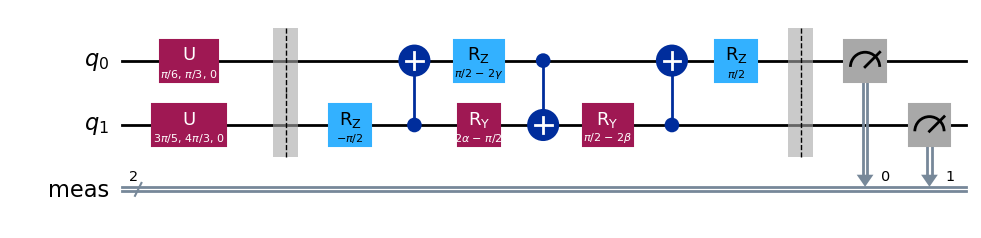

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
import numpy as np

alpha = Parameter(r'2$\alpha$')
beta = Parameter(r'2$\beta$')
gamma = Parameter(r'2$\gamma$')

qr = QuantumRegister(2,'q')

timecirc = QuantumCircuit(qr) 

#initial states from text
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)

timecirc.barrier()

N(alpha,beta,gamma,timecirc,0,1)

timecirc.measure_all()
timecirc.draw('mpl')

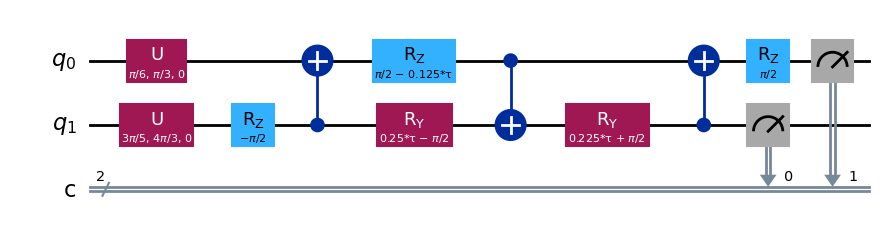

In [ ]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
tau_range = np.linspace(0,10,Nt)

Jx = 0.5
Jy = -0.45
Jz = 0.25

qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')

timecirc = QuantumCircuit(qr,cr) 

#initial states from text
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)


N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)
 
timecirc.measure(qr,[1,0])
timecirc.draw('mpl')

In [9]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
resultz = job.result()[0]

Then this circuit is duplicated with additional rotations before measurement to probe $\langle \hat{S}^{x}\rangle$ and $\langle \hat{S}^{y}\rangle$:

In [ ]:
################################
# circuit to measure <Sx> ######
################################

qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)

N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)
    
timecirc.ry(-np.pi/2,qr)    
timecirc.measure(qr,[1,0])
timecirc.draw()

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
resultx = job.result()[0]


################################
# circuit to measure <Sy> ######
################################

qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)

N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)

timecirc.rz(-np.pi/2,qr) 
timecirc.ry(-np.pi/2,qr)    
timecirc.measure(qr,[1,0])
timecirc.draw()

# pub = (timecirc, tau_range)

# job = sampler.run([pub], shots=nshots)
# resulty = job.result()[0]

Then we run through the standard post-processing:

In [16]:
Sx1 = np.zeros(Nt)
Sy1 = np.zeros(Nt)
Sz1 = np.zeros(Nt)

Sx2 = np.zeros(Nt)
Sy2 = np.zeros(Nt)
Sz2 = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = resultx.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sx1[n] = Sx1[n] + 0.5*simcounts[state]/nshots
        else:
            Sx1[n] = Sx1[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sx2[n] = Sx2[n] + 0.5*simcounts[state]/nshots
        else:
            Sx2[n] = Sx2[n] - 0.5*simcounts[state]/nshots


    simcounts = resulty.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sy1[n] = Sy1[n] + 0.5*simcounts[state]/nshots
        else:
            Sy1[n] = Sy1[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sy2[n] = Sy2[n] + 0.5*simcounts[state]/nshots
        else:
            Sy2[n] = Sy2[n] - 0.5*simcounts[state]/nshots


    simcounts = resultz.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Sz1[n] = Sz1[n] + 0.5*simcounts[state]/nshots
        else:
            Sz1[n] = Sz1[n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Sz2[n] = Sz2[n] + 0.5*simcounts[state]/nshots
        else:
            Sz2[n] = Sz2[n] - 0.5*simcounts[state]/nshots


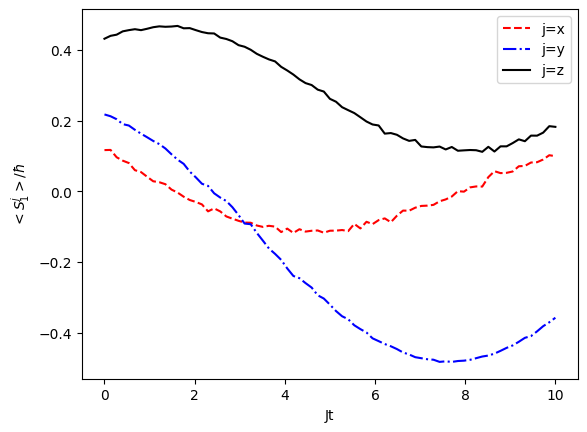

In [17]:
plt.plot(tau_range,Sx1,'r--')
plt.plot(tau_range,Sy1,'b-.')
plt.plot(tau_range,Sz1,'k-')
plt.xlabel('Jt')
plt.ylabel('$<S_{1}^{j}>/\hbar$')
plt.legend(['j=x','j=y','j=z'])
plt.show()

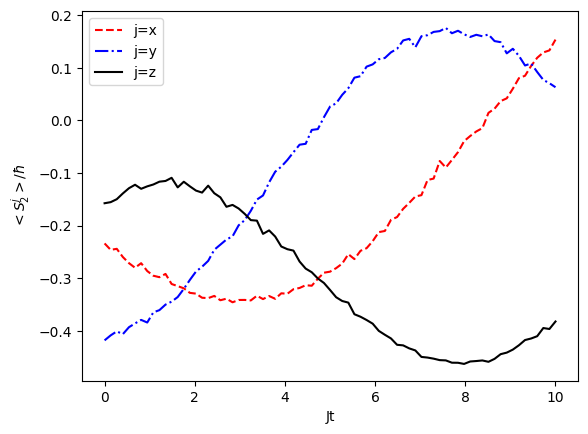

In [18]:
plt.plot(tau_range,Sx2,'r--')
plt.plot(tau_range,Sy2,'b-.')
plt.plot(tau_range,Sz2,'k-')
plt.xlabel('Jt')
plt.ylabel('$<S_{2}^{j}>/\hbar$')
plt.legend(['j=x','j=y','j=z'])
plt.show()

<b>Plot total $z$-component of spin:</b>

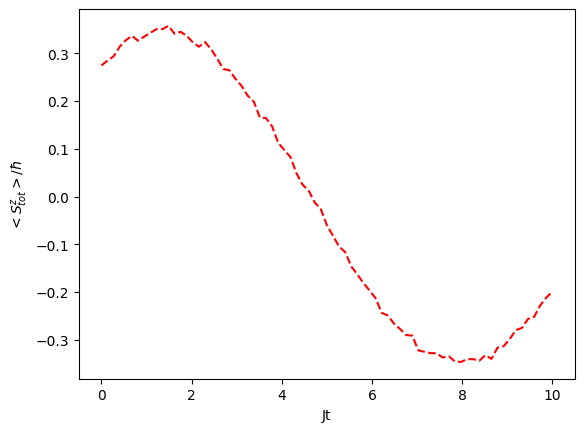

In [19]:
plt.plot(tau_range,Sz1+Sz2,'r--')
plt.xlabel('Jt')
plt.ylabel('$<S_{tot}^{z}>/\hbar$')
plt.show()

To compute energy, one must measure $\langle \hat{S}^{x}_{1}\hat{S}^{x}_{2}\rangle$, $\langle \hat{S}^{y}_{1}\hat{S}^{y}_{2}\rangle$, $\langle \hat{S}^{z}_{1}\hat{S}^{z}_{2}\rangle$. Fortunately, we already have the results needed here from the spin component measurements. We just need to reprocess them to obtain the appropriate correlations:

In [21]:
Sx1Sx2 = np.zeros(Nt)
Sy1Sy2 = np.zeros(Nt)
Sz1Sz2 = np.zeros(Nt)

for n in range(0,Nt):
    simcounts = resultx.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state=='00' or state=='11'):
            Sx1Sx2[n] = Sx1Sx2[n] + 0.25*simcounts[state]/nshots
        else:
            Sx1Sx2[n] = Sx1Sx2[n] - 0.25*simcounts[state]/nshots


    simcounts = resulty.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state=='00' or state=='11'):
            Sy1Sy2[n] = Sy1Sy2[n] + 0.25*simcounts[state]/nshots
        else:
            Sy1Sy2[n] = Sy1Sy2[n] - 0.25*simcounts[state]/nshots

    simcounts = resultx.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state=='00' or state=='11'):
            Sz1Sz2[n] = Sz1Sz2[n] + 0.25*simcounts[state]/nshots
        else:
            Sz1Sz2[n] = Sz1Sz2[n] - 0.25*simcounts[state]/nshots

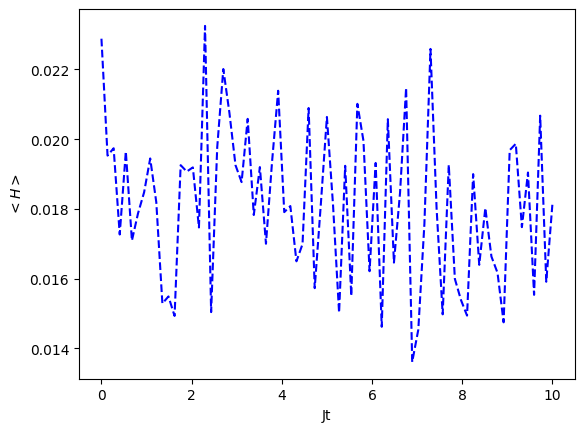

In [25]:
E = Jx*Sx1Sx2 + Jy*Sy1Sy2 + Jz*Sz1Sz2

plt.plot(tau_range,E,'b--')
plt.xlabel('Jt')
plt.ylabel('$<H>$')
plt.show()

Of course, it's also possible to measure the expectation values directly using ```Estimator```. The gains in post-processing start to emerge for the two-spin case. Moreover, all of this can be accomplished with a single circuit, and the simulator results are <i>exact</i> (no statistical fluctuations). 

In [27]:
qr = QuantumRegister(2,'q')
cr = ClassicalRegister(2,'c')

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)

N(Jx*tau/4.0,Jy*tau/4.0,Jz*tau/4.0,timecirc,0,1)

from qiskit.quantum_info import SparsePauliOp

Sx1 = SparsePauliOp.from_list([("IX", 0.5)])
Sy1 = SparsePauliOp.from_list([("IY", 0.5)])
Sz1 = SparsePauliOp.from_list([("IZ", 0.5)])

Sx2 = SparsePauliOp.from_list([("XI", 0.5)])
Sy2 = SparsePauliOp.from_list([("YI", 0.5)])
Sz2 = SparsePauliOp.from_list([("ZI", 0.5)])

H = SparsePauliOp.from_list([("XX", Jx), ("YY", Jy), ("ZZ", Jz)])

pub = (timecirc, [[Sx1], [Sy1], [Sz1], [Sx2], [Sy2], [Sz2], [H]], tau_range)

from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

job_result = estimator.run(pubs=[pub]).result()

In [29]:
Sx1 = job_result[0].data.evs[0]
Sy1 = job_result[0].data.evs[1]
Sz1 = job_result[0].data.evs[2]

Sx2 = job_result[0].data.evs[3]
Sy2 = job_result[0].data.evs[4]
Sz2 = job_result[0].data.evs[5]

E = job_result[0].data.evs[6]

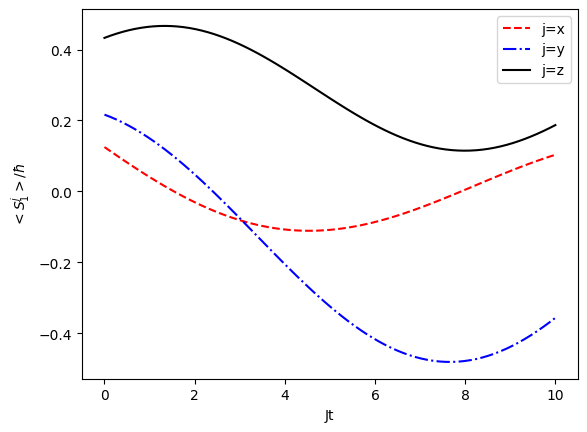

In [30]:
plt.plot(tau_range,Sx1,'r--')
plt.plot(tau_range,Sy1,'b-.')
plt.plot(tau_range,Sz1,'k-')
plt.xlabel('Jt')
plt.ylabel('$<S_{1}^{j}>/\hbar$')
plt.legend(['j=x','j=y','j=z'])
plt.show()

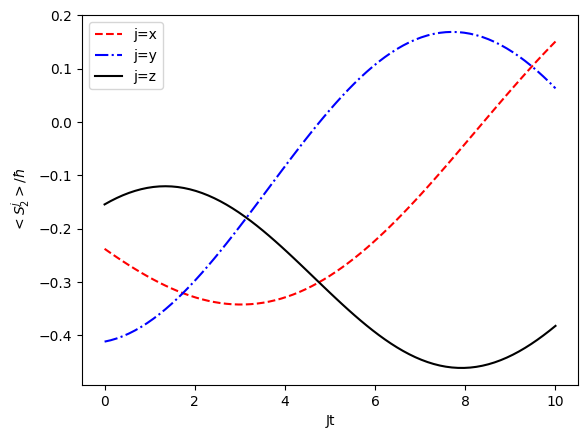

In [31]:
plt.plot(tau_range,Sx2,'r--')
plt.plot(tau_range,Sy2,'b-.')
plt.plot(tau_range,Sz2,'k-')
plt.xlabel('Jt')
plt.ylabel('$<S_{2}^{j}>/\hbar$')
plt.legend(['j=x','j=y','j=z'])
plt.show()

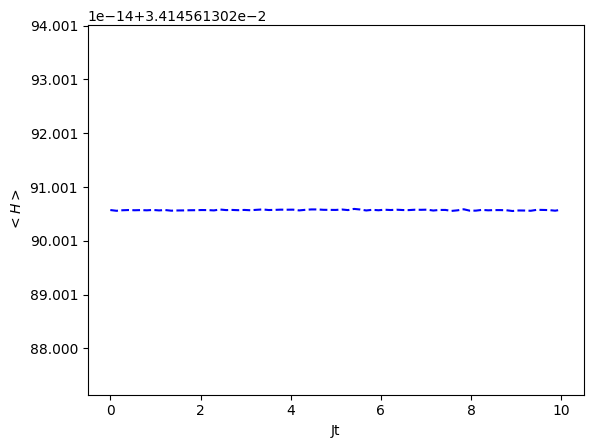

In [32]:
plt.plot(tau_range,E,'b--')
plt.xlabel('Jt')
plt.ylabel('$<H>$')
plt.show()

### Three spins (Fig. 7)

For the case of more than two spins, Lie-Trotter decomposition is necessary to approximate the time evolution operator. For simplicity, we only extract the spin project along the $\hat{z}$ axis. Other components are obtained straightforwardly by performing appropriate rotations to the qubits just before measurement.

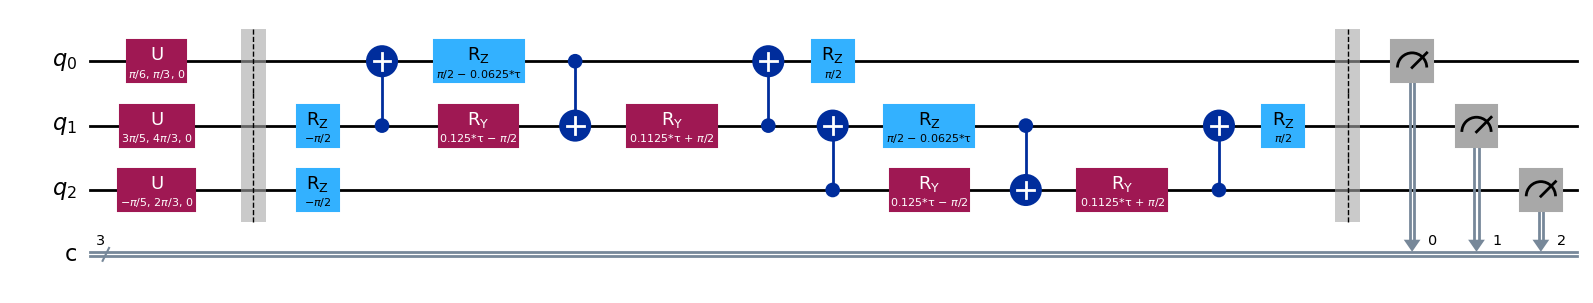

In [6]:
from qiskit.circuit import Parameter
tau = Parameter('τ')
Nt = 75
tau_range = np.linspace(0,10,Nt)

Jx = 0.5
Jy = -0.45
Jz = 0.25

ntrot = 1

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)
timecirc.u(-np.pi/5,2*np.pi/3,0,2)

timecirc.barrier()

for i in range(0,ntrot):
    N(Jx*(tau/ntrot)/4.0,Jy*(tau/ntrot)/4.0,Jz*(tau/ntrot)/4.0,timecirc,0,1)
    N(Jx*(tau/ntrot)/4.0,Jy*(tau/ntrot)/4.0,Jz*(tau/ntrot)/4.0,timecirc,1,2)
    
timecirc.barrier()

timecirc.measure(qr,cr)
timecirc.draw("mpl")

# pub = (timecirc, tau_range)

# nshots = 8192

# job = sampler.run([pub], shots=nshots)
# result = job.result()[0]

In [38]:
#array to store time-dependent expectation values for all three spins

Szt = np.zeros((3,Nt))

for n in range(0,Nt):
    simcounts = result.data.c.get_counts(n)
    states = list(simcounts.keys())
    for j in range(0,len(states)):
        state = states[j]
        if (state[0]=='0'):
            Szt[0,n] = Szt[0,n] + 0.5*simcounts[state]/nshots
        else:
            Szt[0,n] = Szt[0,n] - 0.5*simcounts[state]/nshots

        if (state[1]=='0'):
            Szt[1,n] = Szt[1,n] + 0.5*simcounts[state]/nshots
        else:
            Szt[1,n] = Szt[1,n] - 0.5*simcounts[state]/nshots

        if (state[2]=='0'):
            Szt[2,n] = Szt[2,n] + 0.5*simcounts[state]/nshots
        else:
            Szt[2,n] = Szt[2,n] - 0.5*simcounts[state]/nshots



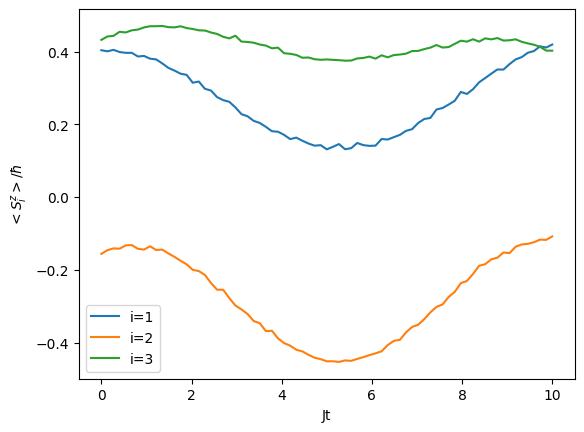

In [ ]:
plt.plot(tau_range,Szt[0,:])
plt.plot(tau_range,Szt[1,:])
plt.plot(tau_range,Szt[2,:])
plt.xlabel('Jt')
plt.ylabel('$<S_{i}^{z}>/\hbar$')


In [ ]:
plt.legend(['i=1','i=2','i=3'])
plt.show()

Lastly, we can see some <i>real</i> gains in efficiency by doing this using ```Estimator``` and extracting all spin components.

In [41]:
tau = Parameter('τ')
Nt = 75
tau_range = np.linspace(0,10,Nt)

Jx = 0.5
Jy = -0.45
Jz = 0.25

ntrot = 100

qr = QuantumRegister(3,'q')
cr = ClassicalRegister(3,'c')

timecirc = QuantumCircuit(qr,cr) 

#initial states
timecirc.u(np.pi/6,np.pi/3,0,0)
timecirc.u(3*np.pi/5,4*np.pi/3,0,1)
timecirc.u(-np.pi/5,2*np.pi/3,0,2)

for i in range(0,ntrot):
    N(Jx*(tau/ntrot)/4.0,Jy*(tau/ntrot)/4.0,Jz*(tau/ntrot)/4.0,timecirc,0,1)
    N(Jx*(tau/ntrot)/4.0,Jy*(tau/ntrot)/4.0,Jz*(tau/ntrot)/4.0,timecirc,1,2)
    
timecirc.draw()

Sx1 = SparsePauliOp.from_list([("IIX", 0.5)])
Sy1 = SparsePauliOp.from_list([("IIY", 0.5)])
Sz1 = SparsePauliOp.from_list([("IIZ", 0.5)])

Sx2 = SparsePauliOp.from_list([("IXI", 0.5)])
Sy2 = SparsePauliOp.from_list([("IYI", 0.5)])
Sz2 = SparsePauliOp.from_list([("IZI", 0.5)])

Sx3 = SparsePauliOp.from_list([("XII", 0.5)])
Sy3 = SparsePauliOp.from_list([("YII", 0.5)])
Sz3 = SparsePauliOp.from_list([("ZII", 0.5)])

pub = (timecirc, [[Sx1], [Sy1], [Sz1], [Sx2], [Sy2], [Sz2], [Sx3], [Sy3], [Sz3]], tau_range)

nshots = 8192

job_result = estimator.run(pubs=[pub]).result()

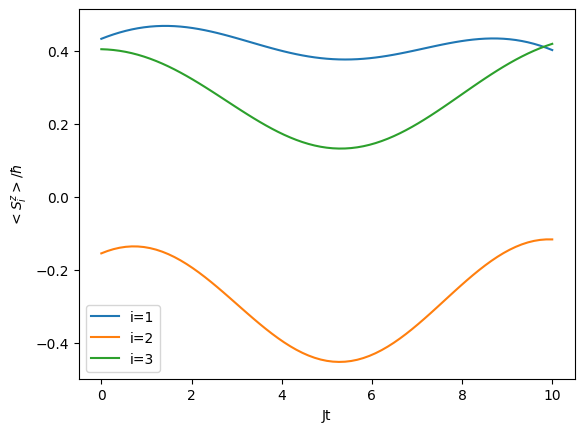

In [43]:
Sx1 = job_result[0].data.evs[0]
Sy1 = job_result[0].data.evs[1]
Sz1 = job_result[0].data.evs[2]

Sx2 = job_result[0].data.evs[3]
Sy2 = job_result[0].data.evs[4]
Sz2 = job_result[0].data.evs[5]

Sx3 = job_result[0].data.evs[6]
Sy3 = job_result[0].data.evs[7]
Sz3 = job_result[0].data.evs[8]

plt.plot(tau_range,Sz1)
plt.plot(tau_range,Sz2)
plt.plot(tau_range,Sz3)
plt.xlabel('Jt')
plt.ylabel('$<S_{i}^{z}>/\hbar$')
plt.legend(['i=1','i=2','i=3'])
plt.show()

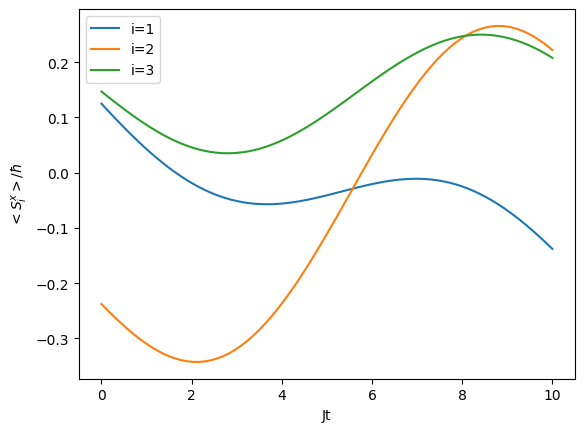

In [44]:
plt.plot(tau_range,Sx1)
plt.plot(tau_range,Sx2)
plt.plot(tau_range,Sx3)
plt.xlabel('Jt')
plt.ylabel('$<S_{i}^{x}>/\hbar$')
plt.legend(['i=1','i=2','i=3'])
plt.show()

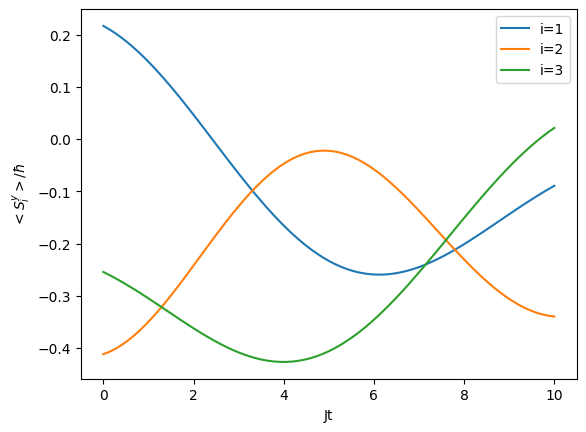

In [45]:
plt.plot(tau_range,Sy1)
plt.plot(tau_range,Sy2)
plt.plot(tau_range,Sy3)
plt.xlabel('Jt')
plt.ylabel('$<S_{i}^{y}>/\hbar$')
plt.legend(['i=1','i=2','i=3'])
plt.show()

## Version information

In [47]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [48]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'